<a href="https://colab.research.google.com/github/johhan27/DS-Unit-2-Linear-Models/blob/master/LS_DS_214_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [59]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [60]:
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [61]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])

    #get the columns to encode 
    binary_columns = []
    for i in df.select_dtypes(exclude=np.number).columns.to_list():
      if len(df[i].value_counts()) < 10:
       binary_columns.append(i)
       #print (df[i].value_counts())

    #there's a No in Chips
    df.loc[df['Chips'] == "No", "Chips"] = float('nan')

    #encode the binary_columns, NaN as 0 and the rest as 1 
    for i in binary_columns:
      df[i] = [0 if pd.isna(j) else 1 for j in df[i]]

    #create new features with Burrito
    four_new_feat = {'California':'california', 'Carne asada':'asada', 'Surf & Turf':'surf', 'Carnitas':'carnitas'}
    for key, value in four_new_feat.items():
      df[value] = [1 if i.strip() == key else 0 for i in df['Burrito']]
    
    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [62]:
filepath = DATA_PATH + 'burritos/burritos.csv'
df = wrangle(filepath)

In [63]:
df.describe(exclude='number') #before wrangle, plain df

,Burrito,Reviewer
count,421,420
unique,132,106
top,California,Scott
freq,101,147


In [64]:
df.describe() #before wrangle, plain df

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,california,asada,surf,carnitas
count,87.000000,87.000000,421.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,0.0,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,3.887356,4.167816,0.059382,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,0.078385,0.016627,0.425178,0.375297,0.365796,0.377672,0.301663,0.218527,0.121140,0.049881,0.049881,0.014252,0.085511,0.083135,0.026128,0.016627,0.016627,0.002375,0.019002,0.090261,0.016627,0.035629,0.040380,0.009501,0.016627,0.004751,0.009501,0.009501,0.002375,NaN,0.011876,0.007126,0.007126,0.004751,0.030879,0.007126,0.002375,0.432304,0.301663,0.068884,0.033254,0.057007
std,0.475396,0.373698,0.236620,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,0.269096,0.128022,0.494958,0.484776,0.482226,0.485382,0.459526,0.413739,0.326678,0.217959,0.217959,0.118668,0.279973,0.276415,0.159706,0.128022,0.128022,0.048737,0.136696,0.286897,0.128022,0.185585,0.197083,0.097125,0.128022,0.068842,0.097125,0.097125,0.048737,NaN,0.108459,0.084214,0.084214,0.068842,0.173195,0.084214,0.048737,0.495985,0.459526,0.253557,0.179513,0.232132
min,2.500000,2.900000,0.000000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,4.000000,0.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.200000,0.000000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.400000,0.000000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.00000

In [65]:
df.info() #before wrangle, plain df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           421 non-null    int64  
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [66]:
#AFTER ORIGINAL WRANGLE 

In [67]:
"""
binary_columns = []
for i in df.select_dtypes(exclude=np.number).columns.to_list():
  if len(df[i].value_counts()) < 10:
    binary_columns.append(i)
    print (df[i].value_counts())
"""

'\nbinary_columns = []\nfor i in df.select_dtypes(exclude=np.number).columns.to_list():\n  if len(df[i].value_counts()) < 10:\n    binary_columns.append(i)\n    print (df[i].value_counts())\n'

In [68]:
#df.loc[df['Chips'] == "No", "Chips"] = float('nan')

In [69]:
#encode the binary_columns 
"""
for i in df.select_dtypes(exclude=np.number).columns.to_list():
  if len(df[i].value_counts()) < 10:
    df[i] = [0 if pd.isna(j) else 1 for j in df[i]]
"""

'\nfor i in df.select_dtypes(exclude=np.number).columns.to_list():\n  if len(df[i].value_counts()) < 10:\n    df[i] = [0 if pd.isna(j) else 1 for j in df[i]]\n'

In [70]:
"""
for i in binary_columns:
  print (df[i].value_counts())
  print (df[i].value_counts().sum()) #all 421
"""

'\nfor i in binary_columns:\n  print (df[i].value_counts())\n  print (df[i].value_counts().sum()) #all 421\n'

In [71]:
df['Burrito'].value_counts()

California        101
Carne asada        29
California         26
Carnitas           23
Surf & Turf        14
                 ... 
El Rusio            1
Especial            1
Mauna Lani          1
Surf and Turf       1
Oaxacalifornia      1
Name: Burrito, Length: 132, dtype: int64

In [72]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.
"""
four_new_feat = {'California':'california', 'Carne asada':'asada', 'Surf & Turf':'surf', 'Carnitas':'carnitas'}
for key, value in four_new_feat.items():
  df[value] = [1 if i.strip() == key else 0 for i in df['Burrito']]
"""

"\nfour_new_feat = {'California':'california', 'Carne asada':'asada', 'Surf & Turf':'surf', 'Carnitas':'carnitas'}\nfor key, value in four_new_feat.items():\n  df[value] = [1 if i.strip() == key else 0 for i in df['Burrito']]\n"

In [73]:
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Reviewer,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,california,asada,surf,carnitas
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,Scott,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,California,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,Scott,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,Carnitas,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,Emily,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1
2016-01-24,Carne asada,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,Ricardo,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-27,California,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,Scott,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,1,1,0,0,0


If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [74]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

In [75]:
df.describe()

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,california,asada,surf,carnitas
count,87.000000,87.000000,421.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,0.0,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,3.887356,4.167816,0.059382,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,0.078385,0.016627,0.425178,0.375297,0.365796,0.377672,0.301663,0.218527,0.121140,0.049881,0.049881,0.014252,0.085511,0.083135,0.026128,0.016627,0.016627,0.002375,0.019002,0.090261,0.016627,0.035629,0.040380,0.009501,0.016627,0.004751,0.009501,0.009501,0.002375,NaN,0.011876,0.007126,0.007126,0.004751,0.030879,0.007126,0.002375,0.432304,0.301663,0.068884,0.033254,0.057007
std,0.475396,0.373698,0.236620,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,0.269096,0.128022,0.494958,0.484776,0.482226,0.485382,0.459526,0.413739,0.326678,0.217959,0.217959,0.118668,0.279973,0.276415,0.159706,0.128022,0.128022,0.048737,0.136696,0.286897,0.128022,0.185585,0.197083,0.097125,0.128022,0.068842,0.097125,0.097125,0.048737,NaN,0.108459,0.084214,0.084214,0.068842,0.173195,0.084214,0.048737,0.495985,0.459526,0.253557,0.179513,0.232132
min,2.500000,2.900000,0.000000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,4.000000,0.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.200000,0.000000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.400000,0.000000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.00000

In [76]:
df.describe(exclude='number')

,Burrito,Reviewer
count,421,420
unique,132,106
top,California,Scott
freq,101,147


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [77]:
#getting numeric columns as features and separate target
features= df.select_dtypes(include=np.number).columns.to_list()
features.remove('Great')

target = 'Great'

X = df[features]
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [78]:
#(y_test == y[(y.index.month==4) & (y.index.year==2019)]) also a way to get a specific month-year
X_train, y_train = X[(X.index.year==2016)|(X.index.year==2017)] , y[(y.index.year==2016)|(y.index.year==2017)]
X_test, y_test = X[(X.index.year > 2017)] , y[(y.index.year > 2017)]

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [79]:
from sklearn.metrics import accuracy_score
y_train_mode = y_train.mode()
baseline_acc = accuracy_score(y_train, [y_train_mode for i in range(len(y_train))])
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5826771653543307


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [101]:
#I have OHE from ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 

#There's no need to use OHE since we created the main Burrito columns ourselves
#On X_train we just have numerical columns.
#Therefore, we just need one preprocessor which can be bundled within the model Pipeline all at once
model_logr = Pipeline(steps=[
                             ('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler()),
                             ('l_regression', LogisticRegression())
])

In [102]:
model_logr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('l_regression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [103]:
training_acc = accuracy_score(y_train, model_logr.predict(X_train))
test_acc = accuracy_score(y_test, model_logr.predict(X_test))

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.9081364829396326
Test MAE: 0.7631578947368421


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [96]:
model_logr.named_steps

{'imputer': SimpleImputer(add_indicator=False, copy=True, fill_value=0, missing_values=nan,
               strategy='median', verbose=0),
 'l_regression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [97]:
model_logr['l_regression'].coef_

array([[ 0.44429511, -0.28950831,  0.00792211,  0.36472655,  0.23927292,
        -0.14817087, -0.13855266,  0.12757331,  0.00490868, -0.12304825,
         0.42529098,  0.62764884,  1.62957839,  1.2924642 ,  1.25510545,
        -0.0029361 ,  0.30914907,  1.7226979 , -0.00955598, -0.02737048,
        -0.00785716, -0.14040588, -0.11873255,  0.35213558, -0.05982756,
         0.07473595,  0.08606437,  0.09534524, -0.28768125, -0.27190667,
        -0.12261071,  0.24484275, -0.64948706, -0.306303  , -0.09569548,
        -0.24089908, -0.00528765,  0.0107484 ,  0.02055165,  0.11414787,
         0.22759163,  0.07474296, -0.12617337, -0.70414229,  0.4115938 ,
         0.05879712,  0.16230372, -0.10278817, -0.02245724, -0.02883256,
         0.15438568,  0.22552053, -0.02404972, -0.34383804,  0.22071521,
        -0.03419671, -0.24293198, -0.11122293, -0.07781179]])

In [98]:
len(model_logr['l_regression'].coef_[0])

59

In [100]:
len(X_test.columns) #apparently Queso was deleted because it was full of NaN

60

In [112]:
final_cols = X.columns.to_list()
final_cols.remove('Queso')

In [113]:
len(final_cols)

59

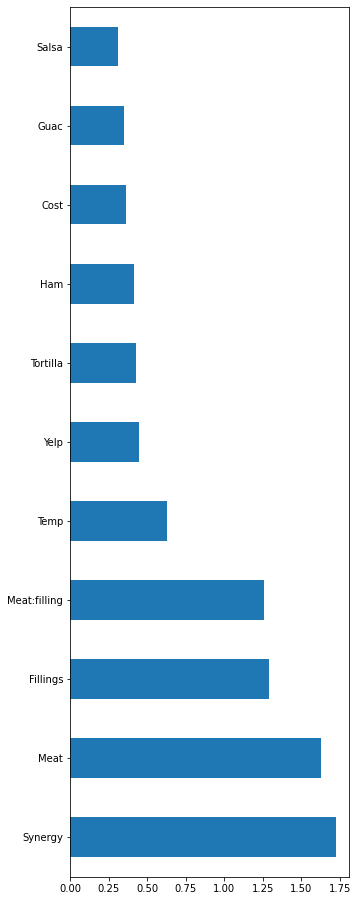

In [116]:
# Create your horizontal barchart here.

##60 columns but 59 coef???
#fig, ax =plt.subplots(1, figsize=[5, 25])
#plt.barh(X.columns, model_logr['l_regression'].coef_[0]) ERROR
%matplotlib inline
fig, ax = plt.subplots(1, figsize=[5, 16])
values = pd.Series(model_logr['l_regression'].coef_[0], final_cols)
values.sort_values(ascending=False)[:11].plot.barh()

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [90]:
# 1: the outputs are int64 and float64; 1s and 0s for predict and pairs of probability for 0 and 1 for predict_proba 
# 2: (38,) for predict and (38,2) for predict_proba
# 3: prediction 1 or 0 for pred and [P(0) P(1)] for predict_proba
# 4: the target value 0 or 1 for pred, and the probability of 0 and 1 for predict_proba 

In [91]:
# Write code here to explore the differences between `predict` and `predict_proba`.
predict = model_logr.predict(X_test)
print(predict.shape, type(predict[0]))
print (predict)

(38,) <class 'numpy.int64'>
[1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1
 1]


In [92]:
predict_proba = model_logr.predict_proba(X_test)
print(predict_proba.shape, type(predict_proba[0][0]))
print (predict_proba)

(38, 2) <class 'numpy.float64'>
[[1.57523256e-05 9.99984248e-01]
 [1.51903220e-03 9.98480968e-01]
 [8.17078058e-01 1.82921942e-01]
 [2.32894935e-05 9.99976711e-01]
 [9.97797739e-01 2.20226142e-03]
 [9.16624256e-01 8.33757438e-02]
 [2.82990674e-02 9.71700933e-01]
 [3.54306465e-04 9.99645694e-01]
 [2.83289203e-01 7.16710797e-01]
 [2.60438451e-02 9.73956155e-01]
 [7.46771994e-01 2.53228006e-01]
 [9.94949090e-01 5.05090980e-03]
 [6.36002184e-01 3.63997816e-01]
 [2.40538411e-01 7.59461589e-01]
 [6.94119094e-02 9.30588091e-01]
 [2.40964932e-01 7.59035068e-01]
 [2.82547954e-01 7.17452046e-01]
 [9.97649202e-01 2.35079804e-03]
 [9.98975197e-01 1.02480321e-03]
 [9.97779218e-01 2.22078247e-03]
 [9.89009165e-01 1.09908349e-02]
 [3.08583925e-02 9.69141607e-01]
 [9.61891707e-01 3.81082925e-02]
 [3.65819655e-01 6.34180345e-01]
 [6.38339146e-02 9.36166085e-01]
 [8.59752909e-01 1.40247091e-01]
 [8.95299370e-01 1.04700630e-01]
 [2.50065590e-05 9.99974993e-01]
 [4.60848396e-02 9.53915160e-01]
 [4.0115671

**Give your written answer here:**

```


```